<a href="https://colab.research.google.com/github/juanchi1789/PIB/blob/colab/Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy
from sys import getsizeof

# Algoritmo de Huffman

In [11]:
def findCode(tree, val):
    code, padre = tree[val]
    if padre != 'r':
        code = findCode(tree, padre) + code
    return code
    
def sortFirst(val):
  return val[0]

In [12]:
######################### COMPRESION ##################################

def HuffmanCompresion(imagen,flag=False):
  if flag: # Para Jpeg 
    lista = imagen
    dtype = lista[0].dtype
    imagen = np.zeros(len(lista),dtype=dtype)
    for i in range(len(lista)):
      imagen[i] = lista[i]
    imagen = imagen.reshape((1,len(lista)))

  filas,columnas = imagen.shape
  N = filas*columnas
  dtype = imagen.dtype

  minimo = np.min(imagen)
  maximo = np.max(imagen)
  R = maximo - minimo + 1
  R = R.astype(int)

  num = np.max(imagen)
  a = math.ceil(math.log(num,2))
  nbins = 2**a
  if flag:
    nbins = R
  
  hist = np.histogram(imagen,bins=nbins)
  h = hist[0] 
  histograma = h/N

  Lista_histograma = [] #lista
  Lista_intensidad = [] #valores

  for i in range(nbins):
    if histograma[i]!=0:
      Lista_histograma.append([histograma[i],minimo+i])
      Lista_intensidad.append(minimo+i)
  
  #print('Lista_histograma: ',Lista_histograma)
  #print('Lista_intensidad: ',Lista_intensidad)
  
  k = 0
  tree = {}
  while len(Lista_histograma)>1:
    Lista_histograma.sort(key = sortFirst, reverse=True) # ordeno de menor a mayor
    a1 = Lista_histograma.pop()
    a2 = Lista_histograma.pop()
    k = k + 1
    kstr = str(k)
    nstr = 'n'+ kstr
    n = [a1[0]+a2[0],nstr] 
    Lista_histograma.append(n)
    tree[a1[1]] = ['0',nstr]
    tree[a2[1]] = ['1',nstr]
  
  tree[nstr] = ['','r']

  dicc= {} #codigo para interpretar tree
  for a in Lista_intensidad:
    code = findCode(tree,a)
    dicc[a] = code

  #print('Diccionario: ',dicc)

  string_out = ''
  for i in range(filas):
    for j in range(columnas):
      pixel = imagen[i,j]
      pixelcode = dicc[pixel]
      string_out = string_out + pixelcode
  dicc_out = dict([(value, key) for key, value in dicc.items()])
  dicc_out['size'] = [filas,columnas]
  dicc_out['dtype'] = dtype

  return string_out, N, dicc_out


##################  DESCOMPRESION  ##################################

def HuffmanDescompresion(comprimida,N,dicc):
  filas,columnas = dicc['size']
  dtype = dicc['dtype']
  imagen_out = np.zeros(filas*columnas,dtype=dtype)
  
  #if N == filas*columnas:
   # print('Dimensiones OK')
  
  pix = 0
  code = ''
  
  for k in range(len(comprimida)):
    code += comprimida[k]
    if code in dicc.keys():
      imagen_out[pix] = dicc[code]
      pix += 1
      code = ''
  imagen_out = imagen_out.reshape((filas,columnas))
  return imagen_out


# Algoritmo de RL

## Horizontal y vertical

In [41]:
def ComprimirLRE_HV(img, modo):
    # modos: 0 horizontal, 1 vertical

    # Horizontal
    if modo == 0:
        modo = "Horizontal"
        fil, col = img.shape
        dtype = img.dtype
        listaRLE = [[fil, col, modo, dtype], []]

        value = img[0, 0]
        cant = 0

        for i in range(col):
            for j in range(fil):
                gris = img[i, j]
                if gris == value:
                    cant += 1
                else:
                    listaRLE[1].append([value, cant])
                    value = gris
                    cant = 1

        listaRLE[1].append([value, cant])



    # Vertical
    if modo == 1:
        modo = "Vertical"
        fil, col = img.shape
        dtype = img.dtype
        listaRLE = [[fil, col, modo, dtype], []]

        value = img[0, 0]
        cant = 0

        for i in range(col):
            for j in range(fil):
                gris = img[i, j]
                if gris == value:
                    cant += 1
                else:

                    listaRLE[1].append([value, cant])

                    value = gris
                    cant = 1

        listaRLE[1].append([value, cant])

    return listaRLE
  
def decoder_rle(lista):
  list_decoded = []
  for i in range(len(lista)):
      value = lista[i][0]
      times = lista[i][1]
      k = 0
      while k < times:
          list_decoded.append(value)
          k += 1
  return list_decoded


## Diagonal

In [42]:
def RLECompresion(imagen,modo):
  #modos: horizontal, vertical, diagonal
  
  filas,columnas = imagen.shape
  dtype = imagen.dtype
  lista_out = [filas,columnas,modo,dtype]

  if modo == 'horizontal':
    targetval = imagen[0,0]
    contador = 0
    for i in range(filas):
      for j in range(columnas):
        currentval = imagen[i,j]
        if currentval == targetval:
          contador += 1
        else:
          lista_out.append(targetval)
          lista_out.append(contador)
          targetval = currentval
          contador = 1
    lista_out.append(targetval)
    lista_out.append(contador)

  elif modo == 'vertical':
    targetval = imagen[0,0]
    contador = 0
    for j in range(columnas):
      for i in range(filas):
        currentval = imagen[i,j]
        if currentval == targetval:
          contador += 1
        else:
          lista_out.append(targetval)
          lista_out.append(contador)
          targetval = currentval
          contador = 1
    lista_out.append(targetval)
    lista_out.append(contador)

  elif modo == 'diagonal':
    lista_out = compresionDiagonal(imagen)

  else:
    print('Modo no reconocido. Modos disponibles: "horizontal", "vertical" o "diagonal".')
    return 
  
  return lista_out


#DIAGONAL!
def compresionDiagonal(imagen):
  nfil,ncol = imagen.shape
  dtype = imagen.dtype
  N = nfil*ncol
  maxfil = nfil-1
  maxcol = ncol-1
  npix = 0
  lastfil, lastcol = 1, -1
  currentfil, currentcol = 0, 0
  lista = [nfil,ncol,'diagonal',dtype]
  targetval= imagen[0,0]
  contador = 0
  while npix<N:
    currentval = imagen[currentfil,currentcol]
    if currentval==targetval:
      contador += 1
    else:
      lista.append(targetval)
      lista.append(contador)
      targetval = currentval
      contador = 1
    if currentfil==0: #en la fila de arriba
      if currentfil!=lastfil: #llega en diagonal
        if currentcol!=maxcol: #no es la ultima col
          lastfil = currentfil
          lastcol = currentcol
          currentcol += 1
        else:  #es la ultima col
          lastcol = currentcol
          lastfil = currentfil
          currentfil += 1
      else: #llega de costado
        lastcol = currentcol
        lastfil = currentfil
        currentfil += 1
        currentcol -= 1
    elif currentfil==maxfil: #en la fila de abajo
      if currentfil!= lastfil and currentcol!=lastcol: #llega en diagonal
        lastfil = currentfil
        lastcol = currentcol
        currentcol += 1
      elif (currentfil!= lastfil and currentcol==lastcol) or (currentfil==lastfil and currentcol!=lastcol): #llega de arriba o de costado
        lastfil = currentfil
        lastcol = currentcol
        currentfil -= 1
        currentcol += 1
    else: #filas del medio
      if currentcol==0: #primera columna
        if currentcol == lastcol: #viene de arriba
          lastfil = currentfil
          lastcol = currentcol
          currentfil -= 1
          currentcol += 1
        else: #viene en diagonal
          lastcol = currentcol
          lastfil = currentfil
          currentfil+=1
      elif currentcol==maxcol: #ultima columna
        if currentcol==lastcol: #viene de arriba
          lastfil = currentfil
          lastcol = currentcol
          currentfil += 1
          currentcol -= 1
        else: #viene en diagonal
          lastcol = currentcol
          lastfil = currentfil
          currentfil += 1
      else:
        if lastfil<currentfil: #viene bajando
          lastfil = currentfil
          lastcol = currentcol
          currentfil += 1
          currentcol -= 1
        else: #viene subiendo
          lastfil = currentfil
          lastcol = currentcol
          currentfil -= 1
          currentcol += 1
    npix += 1
  lista.append(targetval)
  lista.append(contador)

  return lista



########################## DESCOMPRESION #####################################

def RLEDescompresion(lista):
  filas,columnas,modo,dtype = lista[0], lista[1], lista[2], lista[3]
  l = len(lista)
  if modo=='diagonal':
    imagen_out = descompresionDiagonal(lista[4:],[filas,columnas],dtype)
  else:
    imagen_aux = np.zeros(filas*columnas,dtype=dtype)
    pos = 0
    for k in range(4,l-1,2):
      val = lista[k]
      rep = lista[k+1]
      imagen_aux[pos:pos+rep] = val
      pos += rep
    if modo == 'horizontal':
      imagen_out = imagen_aux.reshape((filas,columnas))
    else:
      imagen_out = np.transpose(imagen_aux.reshape((columnas,filas)))    
  return imagen_out


#DIAGONAL!
def descompresionDiagonal(lista,size,dtype):
  fil,col = size
  imagen_out = np.zeros((fil,col),dtype=dtype)
  largo = len(lista)
  numerodepixeles = 0
  fil_ultima, col_ultima = 1, -1
  fil_actual, col_actual = 0, 0
  for k in range(0,largo,2):
    valor = lista[k]
    repeticiones = lista[k+1]
    N = numerodepixeles + repeticiones
    while numerodepixeles < N:
      imagen_out[fil_actual,col_actual] = valor
      if fil_actual == 0: #en la fila de arriba
        if fil_actual != fil_ultima: #llega en diagonal
          if col_actual != col - 1: #no es la ultima col
            fil_ultima = fil_actual
            col_ultima = col_actual
            col_actual = col_actual + 1
          else:  #es la ultima col
            col_ultima = col_actual
            fil_ultima = fil_actual
            fil_actual = fil_actual + 1
        else: #llega de costado
          col_ultima = col_actual
          fil_ultima = fil_actual
          fil_actual = fil_actual + 1
          col_actual = col_actual - 1
      elif fil_actual == fil - 1: #en la fila de abajo
        if fil_actual != fil_ultima and col_actual != col_ultima: #llega en diagonal
          fil_ultima = fil_actual
          col_ultima = col_actual
          col_actual = col_actual + 1
        elif (fil_actual != fil_ultima and col_actual == col_ultima) or (fil_actual == fil_ultima and col_actual != col_ultima): #llega de arriba o de costado
          fil_ultima = fil_actual
          col_ultima = col_actual
          fil_actual = fil_actual - 1
          col_actual = col_actual + 1
      else: #filas del medio
        if col_actual == 0: #primera columna
          if col_actual == col_ultima: #viene de arriba
            fil_ultima = fil_actual
            col_ultima = col_actual
            fil_actual = fil_actual - 1
            col_actual = col_actual + 1
          else: #viene en diagonal
            col_ultima = col_actual
            fil_ultima = fil_actual
            fil_actual = fil_actual + 1
        elif col_actual == col - 1: #ultima columna
          if col_actual == col_ultima: #viene de arriba
            fil_ultima = fil_actual
            col_ultima = col_actual
            fil_actual = fil_actual + 1
            col_actual = col_actual - 1
          else: #viene en diagonal
            col_ultima = col_actual
            fil_ultima = fil_actual
            fil_actual = fil_actual + 1
        else:
          if fil_ultima<fil_actual: #viene bajando
            fil_ultima = fil_actual
            col_ultima = col_actual
            fil_actual = fil_actual + 1
            col_actual = col_actual - 1
          else: #viene subiendo
            fil_ultima = fil_actual
            col_ultima = col_actual
            fil_actual = fil_actual - 1
            col_actual = col_actual + 1
      numerodepixeles = numerodepixeles + 1

  return imagen_out


# JPEG

In [45]:
################## CODIGOS NECESARIOS PRE COMPRESION ########################

def AjustarImagen(imagen): # Para que en la imagen me entren imágenes de 8x8 sin bordes
  m = 8 # Divido en porciones de 8x8
  fil, col = imagen.shape
  restodefil = fil % m
  restodecol = col % m

  if restodefil == 0 and restodecol == 0:
    #print('Imagen más chica que 8x8 píxeles')
    return imagen

  elif restodefil==0: #Filas más chicas que 8 píxeles
    col_add = m-restodecol
    colcopy = imagen[:,col-1].copy().reshape((fil,1))
    for j in range(coladd):
      imagen = np.concatenate((imagen,colcopy),axis=1)

  elif restodecol==0: #Columnas más chicas que 8 píxeles
    fil_add = m-restodefil
    filcopy = imagen[fil-1,:].copy().reshape((1,col))
    for i in range(filadd):
      imagen = np.concatenate((imagen,filcopy))

  else:
    fil_add = m-restodefil
    col_add = m-restodecol
    filcopy = imagen[fil-1,:].copy().reshape((1,col))
    for i in range(fil_add):
      imagen = np.concatenate((imagen,filcopy))
    colcopy = imagen[:,col-1].copy().reshape((fil+fil_add,1))
    for j in range(col_add):
      imagen = np.concatenate((imagen,colcopy),axis=1)

  return imagen


def RLEDescompresionJpeg(lista,dtype):
  fil,col = 8, 8
  imagen_out = np.zeros((fil,col),dtype=dtype)
  numerodepixeles = 0
  fil_ultima, col_ultima = 1, -1
  fil_actual, col_actual = 0, 0

  while fil_ultima != fil - 1 or col_ultima != col - 1:
    valor = lista.pop(0)
    repeticiones = lista.pop(0)
    N = numerodepixeles + repeticiones
    while numerodepixeles < N:
      imagen_out[fil_actual,col_actual] = valor
      if fil_actual == 0: #en la fila de arriba
        if fil_actual != fil_ultima: #llega en diagonal
          if col_actual != col-1: #no es la ultima col
            fil_ultima = fil_actual
            col_ultima = col_actual
            col_actual = col_actual + 1
          else:  #es la ultima col
            col_ultima = col_actual
            fil_ultima = fil_actual
            fil_actual = fil_actual + 1
        else: #llega de costado
          col_ultima = col_actual
          fil_ultima = fil_actual
          fil_actual = fil_actual + 1
          col_actual = col_actual - 1
      elif fil_actual == fil-1: #en la fila de abajo
        if fil_actual != fil_ultima and col_actual != col_ultima: #llega en diagonal
          fil_ultima = fil_actual
          col_ultima = col_actual
          col_actual = col_actual + 1
        elif (fil_actual != fil_ultima and col_actual == col_ultima) or (fil_actual == fil_ultima and col_actual != col_ultima): #llega de arriba o de costado
          fil_ultima = fil_actual
          col_ultima = col_actual
          fil_actual = fil_actual - 1
          col_actual = col_actual + 1
      else: #filas del medio
        if col_actual == 0: #primera columna
          if col_actual == col_ultima: #viene de arriba
            fil_ultima = fil_actual
            col_ultima = col_actual
            fil_actual = fil_actual - 1
            col_actual = col_actual + 1
          else: #viene en diagonal
            col_ultima = col_actual
            fil_ultima = fil_actual
            fil_actual = fil_actual + 1
        elif col_actual == col-1: #ultima columna
          if col_actual == col_ultima: #viene de arriba
            fil_ultima = fil_actual
            col_ultima = col_actual
            fil_actual = fil_actual + 1
            col_actual = col_actual - 1
          else: #viene en diagonal
            col_ultima = col_actual
            fil_ultima = fil_actual
            fil_actual = fil_actual + 1
        else:
          if fil_ultima < fil_actual: #viene bajando
            fil_ultima = fil_actual
            col_ultima = col_actual
            fil_actual = fil_actual + 1
            col_actual = col_actual - 1
          else: #viene subiendo
            fil_ultima = fil_actual
            col_ultima = col_actual
            fil_actual = fil_actual - 1
            col_actual = col_actual + 1
      numerodepixeles = numerodepixeles + 1
  return imagen_out, lista

def escalar(imagen,limites,maxint):
  fil,col = imagen.shape
  imin, imax = limites[0], limites[1]
  imagen_out = np.zeros((fil,col),dtype=imagen.dtype)
  for i in range(fil):
    for j in range(col):
      pixint = imagen[i,j]
      if pixint >= imin and pixint <= imax:
        imagen_out[i,j] = maxint*(pixint-imin)/(imax-imin)     
  return imagen_out


####################### COMPRESION ##################################

def JpegCompresion(imagen):
  fil0, col0 = imagen.shape
  dtype = imagen.dtype
  imagenaux = AjustarImagen(imagen) # Quiero que me entren n-veces los cuadrados de 8x8
  fil, col = imagenaux.shape
  imagenRLE = []
  medias = []
  cuantization = np.zeros((8,8))
  mask = np.arange(30)


  k = 1
  for i in range(8):
    cuantization[i,:] = mask[k:k+16:2]
    k = k + 2
  

  for i in range(0,fil,8):
    for j in range(0,col,8):
      mosaico = imagenaux[i:i+8,j:j+8]
      media = np.mean(mosaico)
      medias.append(media)
      mosaico = mosaico - media # centrado
      #mosaicoTDC = TDC2(mosaico)  
      mosaicoTDC = scipy.fft.dct(mosaico)
      mosaicoCUANT = mosaicoTDC//cuantization
      mosaicoCUANT = mosaicoCUANT.astype(int)
      mosaicoRLE = RLECompresion(mosaicoCUANT,'diagonal')
      mosaicoRLE = mosaicoRLE[4:]
      imagenRLE = imagenRLE + mosaicoRLE
  
  medias.append(dtype)
  imagenhuffman, N,  diccionariohuffman = HuffmanCompresion(imagenRLE, flag = True)

  return imagenhuffman, diccionariohuffman, medias, [fil,col,fil0,col0]





###################### DESCOMPRESION ###########################


def JpegDescompresion(imagen_huff,dicc_huff,medias,shape):
  N = shape[0]
  #Descomprimo Huffman y paso a lista
  vector = HuffmanDescompresion(imagen_huff,N,dicc_huff)
  lista_RLE = []
  for k in range(vector.size):
    lista_RLE.append(vector[0][k])
  
  #Para cada mosaico: descomprimo RLE, multiplico por Matriz de Cuantizacion, antitransformo TDC, sumo la media
  dtype = medias.pop()
  fil,col,fil0,col0 = shape
  imagen_out = np.zeros((fil,col))
  cuantization = np.zeros((8,8))
  mask = np.arange(30)
  k = 1
  for i in range(8):
    cuantization[i,:] = mask[k:k+16:2]
    k = k +2
  m = 0
  for i in range(0,fil,8):
    for j in range(0,col,8):
      mosaico, lista_RLE = RLEDescompresionJpeg(lista_RLE, int)
      mosaico = mosaico*cuantization
      #mosaico = ITDC2(mosaico)
      mosaico = scipy.fft.idct(mosaico)
      mosaico = mosaico + medias[m]
      m = m + 1
      imagen_out[i:i+8,j:j+8] = mosaico
      
  imagen_out = imagen_out[:fil0,:col0]
  lims = [np.min(imagen_out),np.max(imagen_out)]
  if dtype == np.uint8:
    imax = 255
  elif dtype == np.uint16:
    imax = 2**16-1
  else:
    imax = 2**16-1
    print('ERROR: imax=2**16-1')
  imagen_out = escalar(imagen_out,lims,imax)    
  imagen_out = imagen_out.astype(dtype)

  return imagen_out

# Compresion de las imagenes

In [37]:
image1 = cv2.imread('/content/Img2.png',0) # Cerebro
image2 = cv2.imread('/content/img12.png',0)   # Cuadrados
image3 = cv2.imread('/content/img8.jpg',0)    # Con Ruido SyP

## Con Huffman

(-0.5, 927.5, 927.5, -0.5)

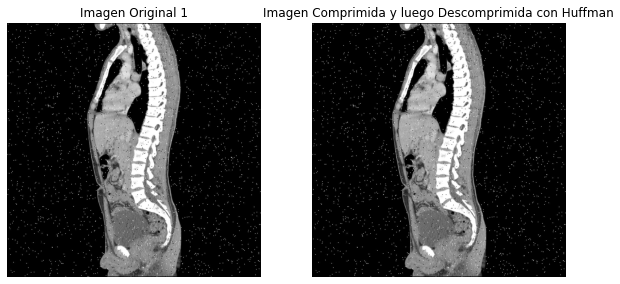

In [18]:
im1_comprimida_Huffman = HuffmanCompresion(image1) #aca tengo en cada posicion, imagen, N y diccionario

im1_descomprimida_Huffman = HuffmanDescompresion(im1_comprimida_Huffman[0],im1_comprimida_Huffman[1],im1_comprimida_Huffman[2])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(image1,cmap='gray')
ax1.set_title('Imagen Original 1')
ax1.axis('off')
ax2.imshow(im1_descomprimida_Huffman,cmap='gray')
ax2.set_title('Imagen Comprimida y luego Descomprimida con Huffman')
ax2.axis('off')


## Con RLE

### Horizontal y vertical

[[0, 11495], [3, 1], [29, 1], [32, 1], [25, 1], [36, 1], [40, 1], [21, 1], [10, 1], [0, 3], [7, 1], [14, 1], [0, 35], [3, 1], [10, 1], [3, 1], [0, 453], [21, 1], [58, 1], [72, 1], [91, 1], [116, 1], [120, 1], [123, 1], [131, 1], [142, 1], [163, 2], [152, 1], [160, 2], [134, 1], [123, 1], [120, 1], [109, 1], [105, 1], [120, 1], [123, 1], [105, 1], [91, 1], [94, 1], [112, 1], [131, 1], [138, 2], [131, 2], [142, 1], [138, 1], [120, 1], [112, 2], [101, 2], [116, 2], [112, 1], [109, 1], [101, 1], [94, 1], [83, 1], [76, 3], [72, 2], [76, 1], [72, 1], [80, 1], [94, 1], [91, 2], [98, 1], [109, 1], [112, 1], [105, 2], [116, 1], [123, 1], [131, 1], [134, 1], [142, 1], [138, 1], [116, 1], [123, 1], [142, 1], [138, 1], [120, 1], [87, 1], [36, 1], [0, 434], [47, 1], [80, 1], [109, 1], [123, 1], [120, 1], [127, 1], [142, 3], [156, 1], [160, 1], [149, 1], [138, 1], [145, 1], [160, 1], [156, 1], [149, 1], [160, 1], [163, 1], [145, 1], [138, 2], [134, 1], [131, 1], [138, 1], [145, 1], [134, 1], [116, 2

(-0.5, 511.5, 511.5, -0.5)

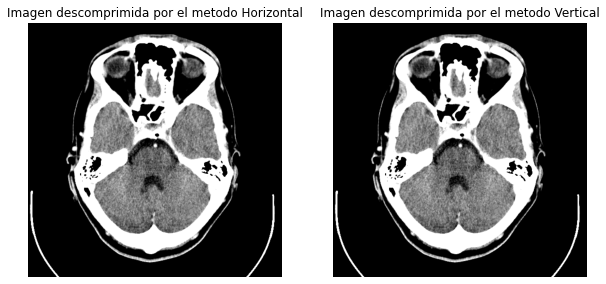

In [23]:
imagen = image1

###### Horizontal ######
codificada = ComprimirLRE_HV(imagen, 0)[1] # Imagen comprimida Horizontal
fil = ComprimirLRE_HV(imagen, 1)[0][0]
col = ComprimirLRE_HV(imagen, 1)[0][1]
deco = np.array(decoder_rle(codificada)) # Imagen decodificada Horizontal
matrix_final_H = deco.reshape(fil,col) # Resultado final de la decodificacion

print(codificada)

###### Vertical ######
codificada = ComprimirLRE_HV(imagen, 1)[1] # Imagen comprimida Horizontal
fil = ComprimirLRE_HV(imagen, 1)[0][0]
col = ComprimirLRE_HV(imagen, 1)[0][1]
deco = np.array(decoder_rle(codificada)) # Imagen decodificada Horizontal
matrix_final_V = deco.reshape(fil,col) # Resultado final de la decodificacion


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

ax1.imshow(matrix_final_H,cmap='gray')
ax1.set_title('Imagen descomprimida por el metodo Horizontal')
ax1.axis('off')

ax2.imshow(matrix_final_V,cmap='gray')
ax2.set_title('Imagen descomprimida por el metodo Vertical')
ax2.axis('off')

### Diagonal

(-0.5, 511.5, 511.5, -0.5)

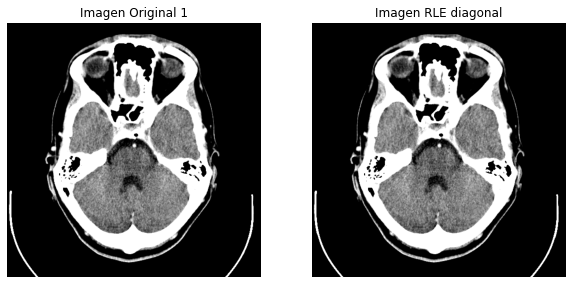

In [28]:
imagen = image1

im1_comprimida_RLEd = RLECompresion(imagen, 'diagonal')
im1_descomprimida_RLEd = RLEDescompresion(im1_comprimida_RLEd)


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

ax1.imshow(imagen,cmap='gray')
ax1.set_title('Imagen Original 1')
ax1.axis('off')

ax2.imshow(im1_descomprimida_RLEd,cmap='gray')
ax2.set_title('Imagen RLE diagonal')
ax2.axis('off')

## Con JPEG

(-0.5, 927.5, 927.5, -0.5)

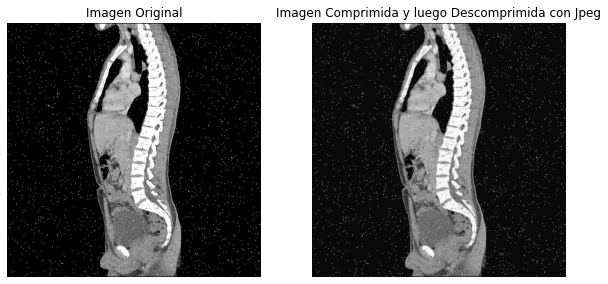

In [46]:
# Con JPEG

imagen = image3

comprimida, diccionario, medias, shape = JpegCompresion(imagen)

descomprimida_jpeg = JpegDescompresion(comprimida, diccionario, medias, shape)

true_comprimida = [comprimida,diccionario,medias,shape]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(imagen,cmap='gray')
ax1.set_title('Imagen Original')
ax1.axis('off')
ax2.imshow(descomprimida_jpeg,cmap='gray')
ax2.set_title('Imagen Comprimida y luego Descomprimida con Jpeg')
ax2.axis('off')

# Pesos de las imagenes

Calculamos los pesos de las imagenes comprimidas por todos los metodos

### Imagenes Orifinales

In [35]:
# Veo los pesos

# Imagen 1
print("Peso de la imagen 1:",getsizeof(image1))
print("Con las medidas",image1.shape)
print("\n")
# Imagen 2
print("Peso de la imagen 2:",getsizeof(image2))
print("Con las medidas",image2.shape)
print("\n")
# Imagen 3
print("Peso de la imagen 3:",getsizeof(image3))
print("Con las medidas",image3.shape)



Peso de la imagen 1: 262256
Con las medidas (512, 512)


Peso de la imagen 2: 1440112
Con las medidas (1200, 1200)


Peso de la imagen 3: 861296
Con las medidas (928, 928)


## Con Huffman

In [38]:
# Imagenes comprimidas

im_comprimida_Huffman_1 = HuffmanCompresion(image1)
print("Peso de la imagen 1 comprimida por huffman:",getsizeof(im_comprimida_Huffman_1))

im_comprimida_Huffman_2 = HuffmanCompresion(image2)
print("Peso de la imagen 2 comprimida por huffman:",getsizeof(im_comprimida_Huffman_2))

im_comprimida_Huffman_3 = HuffmanCompresion(image3)
print("Peso de la imagen 3 comprimida por huffman:",getsizeof(im_comprimida_Huffman_3))

Peso de la imagen 1 comprimida por huffman: 80
Peso de la imagen 2 comprimida por huffman: 80
Peso de la imagen 3 comprimida por huffman: 80


## Con RLE

In [39]:
# Imagenes comprimidas

  # Horizontal
codificada_h_1 = ComprimirLRE_HV(image1, 0)
print("Peso de la imagen 1 comprimida por RLE Horizontal:",getsizeof(codificada_h_1))
codificada_h_2 = ComprimirLRE_HV(image2, 0)
print("Peso de la imagen 2 comprimida por RLE Horizontal:",getsizeof(codificada_h_2))
codificada_h_3 = ComprimirLRE_HV(image3, 0)
print("Peso de la imagen 3 comprimida por RLE Horizontal:",getsizeof(codificada_h_3))

  # Vertical
codificada_v_1 = ComprimirLRE_HV(image1, 1)
print("Peso de la imagen 1 comprimida por RLE Vertical:",getsizeof(codificada_v_1))
codificada_v_2 = ComprimirLRE_HV(image2, 1)
print("Peso de la imagen 2 comprimida por RLE Vertical:",getsizeof(codificada_v_2))
codificada_v_3 = ComprimirLRE_HV(image3, 1)
print("Peso de la imagen 3 comprimida por RLE Vertical:",getsizeof(codificada_v_3))


  # Diagonal
codificada_d_1  = RLECompresion(image1, 'diagonal')
print("Peso de la imagen 1 comprimida por RLE Diagonal:",getsizeof(codificada_d_1))
codificada_d_2  = RLECompresion(image2, 'diagonal')
print("Peso de la imagen 2 comprimida por RLE Diagonal:",getsizeof(codificada_d_2))
codificada_d_3  = RLECompresion(image3, 'diagonal')
print("Peso de la imagen 3 comprimida por RLE Diagonal:",getsizeof(codificada_d_3))


Peso de la imagen 1 comprimida por RLE Horizontal: 88
Peso de la imagen 2 comprimida por RLE Horizontal: 88
Peso de la imagen 3 comprimida por RLE Horizontal: 88
Peso de la imagen 1 comprimida por RLE Vertical: 88
Peso de la imagen 2 comprimida por RLE Vertical: 88
Peso de la imagen 3 comprimida por RLE Vertical: 88
Peso de la imagen 1 comprimida por RLE Diagonal: 1174056
Peso de la imagen 2 comprimida por RLE Diagonal: 1671800
Peso de la imagen 3 comprimida por RLE Diagonal: 5429656


## Con JPEG

In [40]:
# Imagenes comprimidas

comprimida, diccionario, medias, shape = JpegCompresion(image1)
comprimida_1 = [comprimida,diccionario,medias,shape]
print("Peso de la imagen 1 comprimida por JPEG:",getsizeof(comprimida_1))

comprimida, diccionario, medias, shape = JpegCompresion(image2)
comprimida_2 = [comprimida,diccionario,medias,shape]
print("Peso de la imagen 2 comprimida por JPEG:",getsizeof(comprimida_2))

comprimida, diccionario, medias, shape = JpegCompresion(image3)
comprimida_3 = [comprimida,diccionario,medias,shape]
print("Peso de la imagen 3 comprimida por JPEG:",getsizeof(comprimida_3))

Peso de la imagen 1 comprimida por JPEG: 104
Peso de la imagen 2 comprimida por JPEG: 104
Peso de la imagen 3 comprimida por JPEG: 104
